In [ ]:
import pandas as pd
from google.colab import files
import io
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns
!pip install arch
from arch import arch_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import numpy as np


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 45.5 MB/s eta 0:00:00


# Data Preperation

The file we have received for the project is XLS file so we had to converc it to csv for the simplisity of the file reading
The file included utf-8 values which had to be eliminated pre-uploading the file to the notebook

In [ ]:
df_experiment1 = pd.read_csv('/content/run2_1 (1).csv')
df_experiment1 = df_experiment1.set_index('Time Stamp')
df_experiment1.index = pd.to_datetime(df_experiment1.index)
df_experiment1.drop(index=df_experiment1.index[0], axis=0, inplace=True)


In [ ]:
df_experiment1

,1-pH_Dev1,2-DO_Dev1,Agitation_Dev1,Air_Dev1,CO2_Dev1,GasFlow_Dev1,N2_Dev1,O2_Dev1,Pump1_Dev1,Pump2_Dev1,Pump3_Dev1,Temperature_Dev1
Time Stamp,,,,,,,,,,,,
2023-01-23 18:54:00,6.03,28.87,336,100.0,0,1.00,0,0.0,0.0,0.0,0.0,28.00
2023-01-23 18:55:00,6.03,29.09,338,100.0,0,1.00,0,0.0,0.0,0.0,0.0,28.00
2023-01-23 18:56:00,6.03,29.33,339,100.0,0,1.00,0,0.0,0.0,0.0,0.0,28.00
2023-01-23 18:57:00,6.03,29.55,342,100.0,0,1.00,0,0.0,0.0,0.0,0.0,28.00
2023-01-23 18:58:00,6.02,29.76,342,100.0,0,0.98,0,0.0,0.0,0.0,0.0,28.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26 08:33:00,6.06,29.83,477,100.0,0,0.50,0,0.0,0.0,0.0,0.0,12.83
2023-01-26 08:34:00,6.05,29.90,477,100.0,0,0.50,0,0.0,0.0,0.0,0.0,12.84
2023-01-26 08:35:00,6.06,30.01,477,100.0,0,0.50,0,0.0,0.0,0.0,0.0,12.84


Dictionary:
Time Stamp -
2-DO_Dev2 -
Agitation_Dev2 -
Air_Dev2 -
GasFlow_Dev2 -
O2_Dev2 -
Pump1_Dev2 -
Pump2_Dev2 - italicized text
Pump3_Dev2 -
Temperature_Dev2 -

Droping the unnecessary columns:
1-pH_Dev2 - doesn't have any effect on the research mission
N2_Dev2 - All '0' values
CO2_Dev2 - italicized text

In [ ]:
df_experiment1 = df_experiment1.dropna(axis =0, how = 'all')
df_experiment1 = df_experiment1.dropna(axis =1, how = 'all')
df_experiment1

,1-pH_Dev1,2-DO_Dev1,Agitation_Dev1,Air_Dev1,CO2_Dev1,GasFlow_Dev1,N2_Dev1,O2_Dev1,Pump1_Dev1,Pump2_Dev1,Pump3_Dev1,Temperature_Dev1
Time Stamp,,,,,,,,,,,,
2023-01-23 18:54:00,6.03,28.87,336,100.0,0,1.00,0,0.0,0.0,0.0,0.0,28.00
2023-01-23 18:55:00,6.03,29.09,338,100.0,0,1.00,0,0.0,0.0,0.0,0.0,28.00
2023-01-23 18:56:00,6.03,29.33,339,100.0,0,1.00,0,0.0,0.0,0.0,0.0,28.00
2023-01-23 18:57:00,6.03,29.55,342,100.0,0,1.00,0,0.0,0.0,0.0,0.0,28.00
2023-01-23 18:58:00,6.02,29.76,342,100.0,0,0.98,0,0.0,0.0,0.0,0.0,28.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26 08:33:00,6.06,29.83,477,100.0,0,0.50,0,0.0,0.0,0.0,0.0,12.83
2023-01-26 08:34:00,6.05,29.90,477,100.0,0,0.50,0,0.0,0.0,0.0,0.0,12.84
2023-01-26 08:35:00,6.06,30.01,477,100.0,0,0.50,0,0.0,0.0,0.0,0.0,12.84


In [ ]:
df_TIME=df_experiment1.index

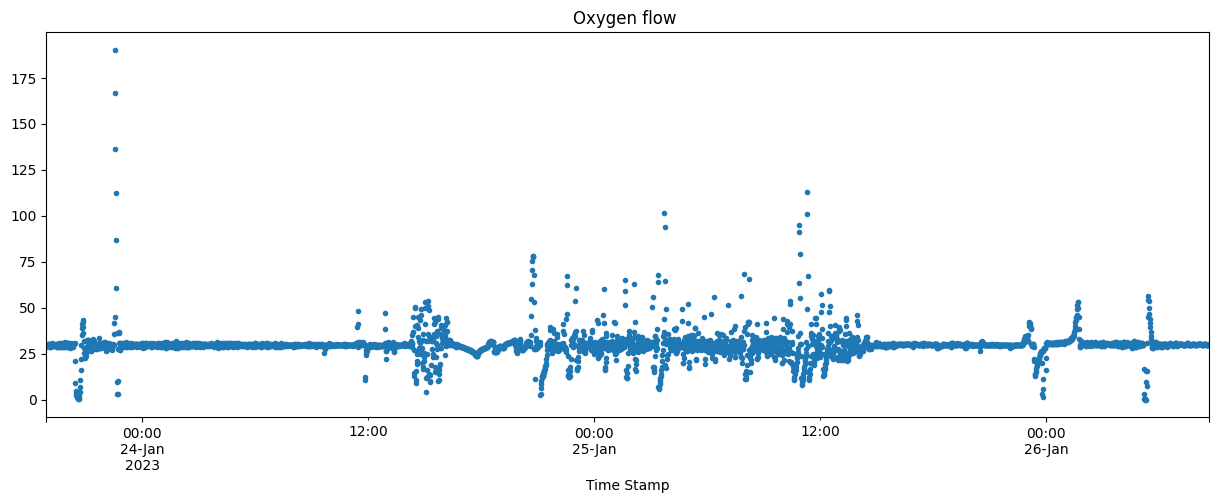

In [ ]:
df_experiment1['2-DO_Dev1'].plot(style='.',
        figsize=(15, 5),
        title='Oxygen flow ')
plt.show()

# **Processing**




# **Train/Test Split**

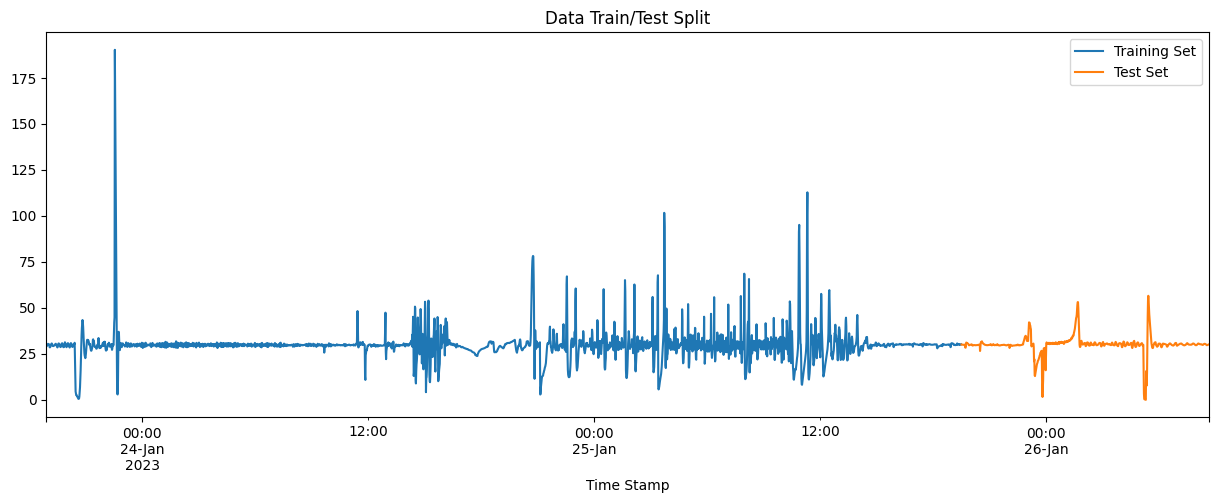

In [ ]:

train = df_experiment1['2-DO_Dev1'].loc[df_TIME < '2023-01-25 19:30:00']
test = df_experiment1['2-DO_Dev1'].loc[df_TIME >= '2023-01-25 19:30:00']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

**Visualisation graph of the train- test split, from the graph we get the feeling of the data behavior implements the DO-DEV2 VS TIme stemp**

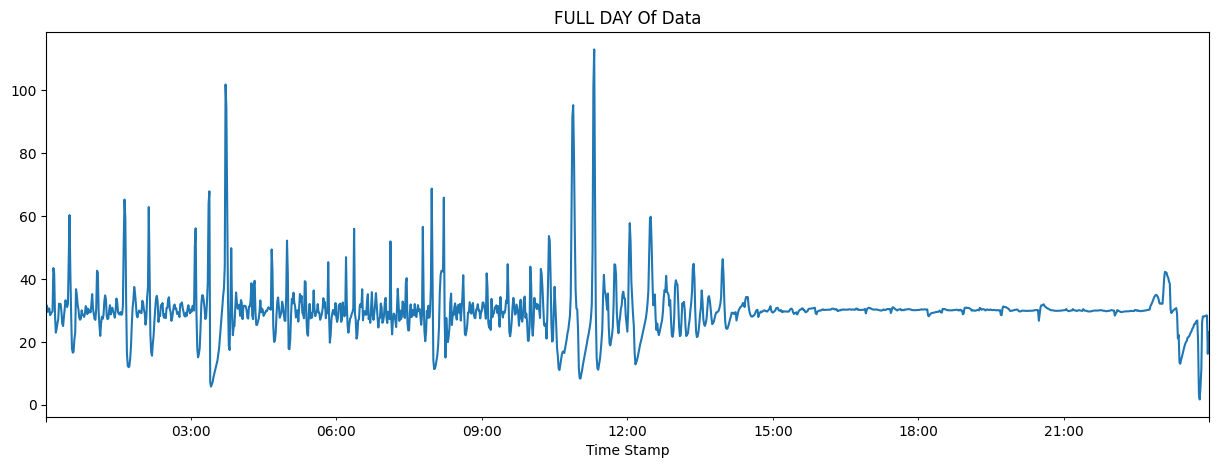

In [ ]:
df_experiment1['2-DO_Dev1'].loc[(df_TIME > '2023-01-25 00:00:00') & (df_TIME <= '2023-01-25 23:59:59')] \
    .plot(figsize=(15, 5), title='FULL DAY Of Data')
plt.show()

# **fEATURE CREATION**

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day
    df['minutes']=df.index.minute
    return df

df_experiment1 = create_features(df_experiment1)
df_experiment1

,1-pH_Dev1,2-DO_Dev1,Agitation_Dev1,Air_Dev1,CO2_Dev1,GasFlow_Dev1,N2_Dev1,O2_Dev1,Pump1_Dev1,Pump2_Dev1,Pump3_Dev1,Temperature_Dev1,hour,dayofweek,month,year,dayofyear,minutes
Time Stamp,,,,,,,,,,,,,,,,,,
2023-01-23 18:54:00,6.03,28.87,336,100.0,0,1.00,0,0.0,0.0,0.0,0.0,28.00,18,0,1,2023,23,54
2023-01-23 18:55:00,6.03,29.09,338,100.0,0,1.00,0,0.0,0.0,0.0,0.0,28.00,18,0,1,2023,23,55
2023-01-23 18:56:00,6.03,29.33,339,100.0,0,1.00,0,0.0,0.0,0.0,0.0,28.00,18,0,1,2023,23,56
2023-01-23 18:57:00,6.03,29.55,342,100.0,0,1.00,0,0.0,0.0,0.0,0.0,28.00,18,0,1,2023,23,57
2023-01-23 18:58:00,6.02,29.76,342,100.0,0,0.98,0,0.0,0.0,0.0,0.0,28.00,18,0,1,2023,23,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26 08:33:00,6.06,29.83,477,100.0,0,0.50,0,0.0,0.0,0.0,0.0,12.83,8,3,1,2023,26,33
2023-01-26 08:34:00,6.05,29.90,477,100.0,0,0.50,0,0.0,0.0,0.0,0.0,12.84,8,3,1,2023,26,34
2023-01-26 08:35:00,6.06,30.01,477,100.0,0,0.50,0,0.0,0.0,0.0,0.0,12.84,8,3,1,2023,26,35


# **Visualize our Target correlation**

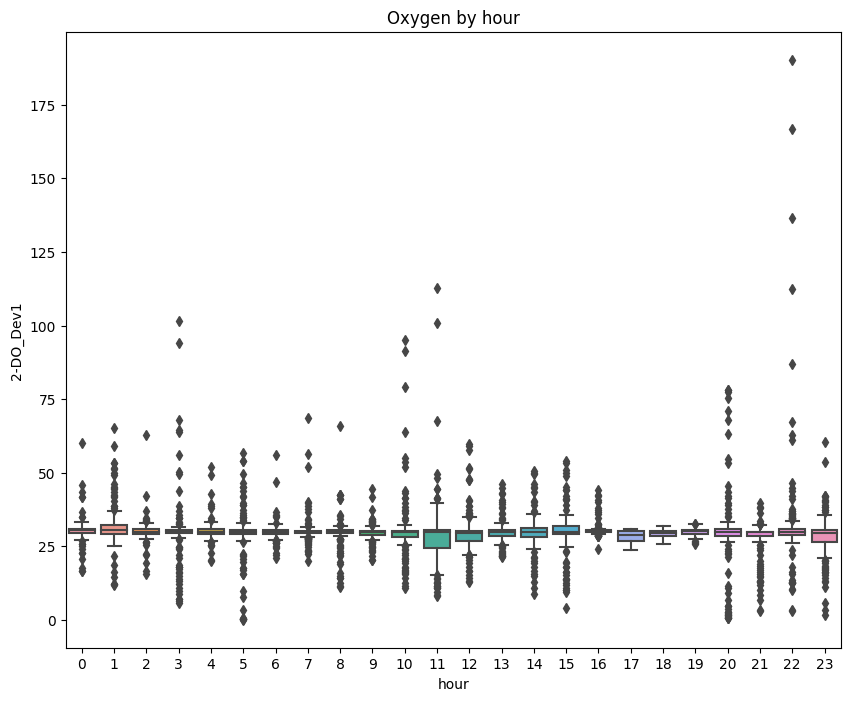

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_experiment1, x='hour', y='2-DO_Dev1')
ax.set_title('Oxygen by hour')
plt.show()

**The AVG value for each hour of the day The AVG value for each hour of the day**

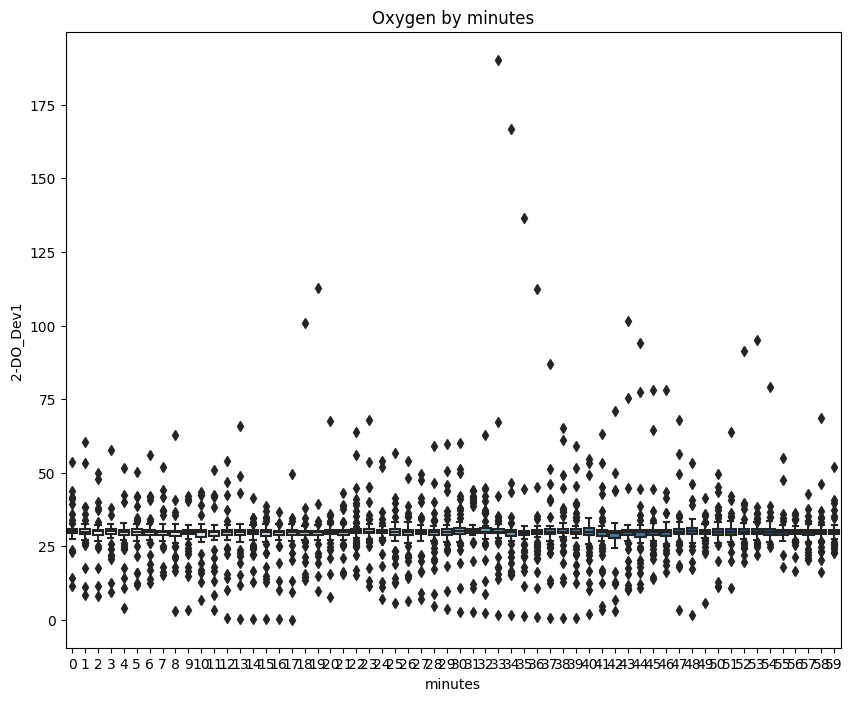

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_experiment1, x='minutes', y='2-DO_Dev1', palette='Blues')
ax.set_title('Oxygen by minutes')
plt.show()


# **Arch**

In [ ]:
model = arch_model(train, mean='Zero', vol='ARCH', p=15)

In [ ]:
model_fit = model.fit()

Iteration:      1,   Func. Count:     18,   Neg. LLF: 14004.023176366973
Iteration:      2,   Func. Count:     35,   Neg. LLF: 14032.988094042503
Iteration:      3,   Func. Count:     58,   Neg. LLF: 14260.10155218163
Iteration:      4,   Func. Count:     79,   Neg. LLF: 14005.437982534902
Iteration:      5,   Func. Count:     98,   Neg. LLF: 14001.687021107164
Iteration:      6,   Func. Count:    116,   Neg. LLF: 14000.470849655874
Iteration:      7,   Func. Count:    133,   Neg. LLF: 14001.390136631717
Iteration:      8,   Func. Count:    151,   Neg. LLF: 14000.681638437592
Iteration:      9,   Func. Count:    169,   Neg. LLF: 14000.31982977399
Iteration:     10,   Func. Count:    187,   Neg. LLF: 14000.59709194357
Iteration:     11,   Func. Count:    205,   Neg. LLF: 14000.310376378555
Iteration:     12,   Func. Count:    223,   Neg. LLF: 14000.2244895519
Iteration:     13,   Func. Count:    241,   Neg. LLF: 13999.712125060989
Iteration:     14,   Func. Count:    259,   Neg. LLF: 13

/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


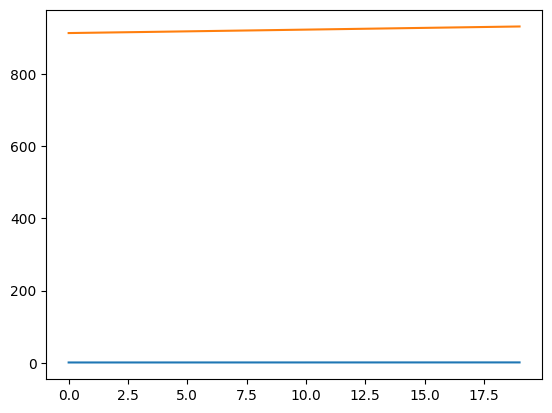

In [ ]:
yhat = model_fit.forecast(horizon=20)
# plot the actual variance
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-20:])
# plot forecast variance
plt.plot(yhat.variance.values[-1, :])
plt.show()

# **Sarima**

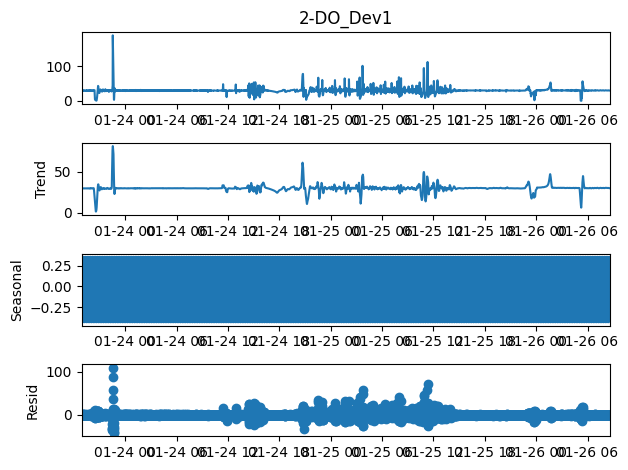

In [ ]:
decomposition = seasonal_decompose(
df_experiment1['2-DO_Dev1'], model='additive', period=12)

decomposition.plot()
plt.show()

In [ ]:
train=train.to_frame()
test=test.to_frame()


train.set_axis([ '2-DO_Dev1'],
                    axis=1,inplace=True)
test.set_axis([ '2-DO_Dev1'],
                    axis=1,inplace=True)


<ipython-input-16-2f7210a9cd5a>:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  train.set_axis([ '2-DO_Dev1'],
<ipython-input-16-2f7210a9cd5a>:7: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  test.set_axis([ '2-DO_Dev1'],


In [ ]:
train = df_experiment1.loc[df_TIME < '2023-01-25 19:30:00']
test = df_experiment1.loc[df_TIME >= '2023-01-25 19:30:00']


In [ ]:
model = SARIMAX(
train['2-DO_Dev1'], order= (2, 1, 1), seasonal_order=(1, 1, 1, 12))

result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [ ]:
forecast = result.get_forecast(steps=len(test['2-DO_Dev1']))
pred_ci = forecast.predicted_mean

mse = mean_squared_error(test['2-DO_Dev1'], pred_ci)
rmse = np.sqrt(mse)

print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

Mean Squared Error:  27.75030260127577
Root Mean Squared Error:  5.2678555979901125


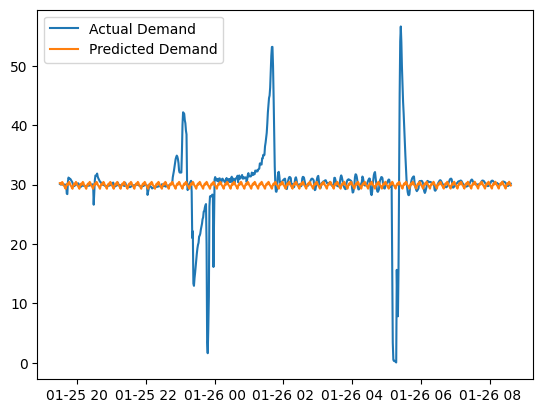

In [ ]:
plt.plot(test['2-DO_Dev1'], label='Actual Demand')
plt.plot(pred_ci, label='Predicted Demand')

plt.legend()
plt.show()

In [ ]:
pred_ci

2023-01-25 19:30:00    30.253710
2023-01-25 19:31:00    30.285050
2023-01-25 19:32:00    30.014531
2023-01-25 19:33:00    30.219476
2023-01-25 19:34:00    30.436348
                         ...    
2023-01-26 08:33:00    30.255010
2023-01-26 08:34:00    30.482867
2023-01-26 08:35:00    30.349704
2023-01-26 08:36:00    30.028623
2023-01-26 08:37:00    29.857617
Freq: T, Name: predicted_mean, Length: 788, dtype: float64

In [ ]:
corr = df_experiment1.corr()
corr.style.background_gradient(cmap='coolwarm')

<ipython-input-22-b343d466f491>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_experiment1.corr()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,1-pH_Dev1,2-DO_Dev1,Air_Dev1,CO2_Dev1,GasFlow_Dev1,N2_Dev1,O2_Dev1,Pump1_Dev1,Pump2_Dev1,Pump3_Dev1,Temperature_Dev1,hour,dayofweek,month,year,dayofyear,minutes
1-pH_Dev1,1.000000,-0.000312,0.197897,nan,0.024609,nan,-0.197967,-0.005979,-0.023204,-0.219957,-0.155903,0.262686,-0.076011,nan,nan,-0.076011,-0.013143
2-DO_Dev1,-0.000312,1.000000,0.053707,nan,-0.024313,nan,-0.054792,-0.000782,0.000152,0.018509,-0.011757,-0.032506,0.022214,nan,nan,0.022214,0.030861
Air_Dev1,0.197897,0.053707,1.000000,nan,-0.206385,nan,-0.999988,0.002983,-0.001787,-0.045218,0.028462,-0.216083,-0.308220,nan,nan,-0.308220,-0.004909
CO2_Dev1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
GasFlow_Dev1,0.024609,-0.024313,-0.206385,nan,1.000000,nan,0.206523,-0.007198,0.023616,0.012451,0.401994,0.265936,-0.453145,nan,nan,-0.453145,-0.008494
N2_Dev1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
O2_Dev1,-0.197967,-0.054792,-0.999988,nan,0.206523,nan,1.000000,-0.002977,0.001886,0.045185,-0.028417,0.216156,0.308214,nan,nan,0.308214,0.004864
Pump1_Dev1,-0.005979,-0.000782,0.002983,nan,-0.007198,nan,-0.002977,1.000000,-0.000990,-0.003090,0.029736,0.027767,-0.022479,nan,nan,-0.022479,0.016681
Pump2_Dev1,-0.023204,0.000152,-0.001787,nan,0.023616,nan,0.001886,-0.000990,1.000000,0.042752,0.017391,0.024495,-0.012281,nan,nan,-0.012281,0.005560
Pump3_Dev1,-0.219957,0.018509,-0.045218,nan,0.012451,nan,0.045185,-0.003090,0.042752,1.000000,0.107274,0.006580,0.001033,nan,nan,0.001033,-0.015194


In [ ]:

df_experiment1.dtypes

1-pH_Dev1           float64
2-DO_Dev1           float64
Agitation_Dev1       object
Air_Dev1            float64
CO2_Dev1              int64
GasFlow_Dev1        float64
N2_Dev1               int64
O2_Dev1             float64
Pump1_Dev1          float64
Pump2_Dev1          float64
Pump3_Dev1          float64
Temperature_Dev1    float64
hour                  int64
dayofweek             int64
month                 int64
year                  int64
dayofyear             int64
minutes               int64
dtype: object

In [ ]:
df_experiment1['Agitation_Dev1'] = df_experiment1['Agitation_Dev1'].str.replace(',','').astype(float)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

normalized_data = scaler.fit_transform(df_experiment1)

print(normalized_data)

[[0.375      0.15138772 0.28       ... 0.         0.         0.91525424]
 [0.375      0.15254415 0.28166667 ... 0.         0.         0.93220339]
 [0.375      0.15380572 0.2825     ... 0.         0.         0.94915254]
 ...
 [0.5        0.15738015 0.3975     ... 0.         1.         0.59322034]
 [0.5        0.15785324 0.3975     ... 0.         1.         0.61016949]
 [0.45833333 0.15811606 0.3975     ... 0.         1.         0.62711864]]


In [ ]:
normalized_df = pd.DataFrame(normalized_data, columns=df_experiment1.columns)

print(normalized_df)


      1-pH_Dev1  2-DO_Dev1  Agitation_Dev1  Air_Dev1  CO2_Dev1  GasFlow_Dev1  \
0      0.375000   0.151388        0.280000       1.0       0.0      0.147727   
1      0.375000   0.152544        0.281667       1.0       0.0      0.147727   
2      0.375000   0.153806        0.282500       1.0       0.0      0.147727   
3      0.375000   0.154962        0.285000       1.0       0.0      0.147727   
4      0.333333   0.156066        0.285000       1.0       0.0      0.142045   
...         ...        ...             ...       ...       ...           ...   
3699   0.500000   0.156434        0.397500       1.0       0.0      0.005682   
3700   0.458333   0.156802        0.397500       1.0       0.0      0.005682   
3701   0.500000   0.157380        0.397500       1.0       0.0      0.005682   
3702   0.500000   0.157853        0.397500       1.0       0.0      0.005682   
3703   0.458333   0.158116        0.397500       1.0       0.0      0.005682   

      N2_Dev1  O2_Dev1  Pump1_Dev1  Pum

In [ ]:
normalized_df.index=df_TIME

In [ ]:
normalized_df

,1-pH_Dev1,2-DO_Dev1,Agitation_Dev1,Air_Dev1,CO2_Dev1,GasFlow_Dev1,N2_Dev1,O2_Dev1,Pump1_Dev1,Pump2_Dev1,Pump3_Dev1,Temperature_Dev1,hour,dayofweek,month,year,dayofyear,minutes
Time Stamp,,,,,,,,,,,,,,,,,,
2023-01-23 18:54:00,0.375000,0.151388,0.280000,1.0,0.0,0.147727,0.0,0.0,0.0,0.0,0.0,0.993455,0.782609,0.0,0.0,0.0,0.0,0.915254
2023-01-23 18:55:00,0.375000,0.152544,0.281667,1.0,0.0,0.147727,0.0,0.0,0.0,0.0,0.0,0.993455,0.782609,0.0,0.0,0.0,0.0,0.932203
2023-01-23 18:56:00,0.375000,0.153806,0.282500,1.0,0.0,0.147727,0.0,0.0,0.0,0.0,0.0,0.993455,0.782609,0.0,0.0,0.0,0.0,0.949153
2023-01-23 18:57:00,0.375000,0.154962,0.285000,1.0,0.0,0.147727,0.0,0.0,0.0,0.0,0.0,0.993455,0.782609,0.0,0.0,0.0,0.0,0.966102
2023-01-23 18:58:00,0.333333,0.156066,0.285000,1.0,0.0,0.142045,0.0,0.0,0.0,0.0,0.0,0.993455,0.782609,0.0,0.0,0.0,0.0,0.983051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26 08:33:00,0.500000,0.156434,0.397500,1.0,0.0,0.005682,0.0,0.0,0.0,0.0,0.0,0.000654,0.347826,1.0,0.0,0.0,1.0,0.559322
2023-01-26 08:34:00,0.458333,0.156802,0.397500,1.0,0.0,0.005682,0.0,0.0,0.0,0.0,0.0,0.001309,0.347826,1.0,0.0,0.0,1.0,0.576271
2023-01-26 08:35:00,0.500000,0.157380,0.397500,1.0,0.0,0.005682,0.0,0.0,0.0,0.0,0.0,0.001309,0.347826,1.0,0.0,0.0,1.0,0.593220


In [ ]:
corr = normalized_df.corr()
corr.style.background_gradient(cmap='coolwarm')

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,1-pH_Dev1,2-DO_Dev1,Agitation_Dev1,Air_Dev1,CO2_Dev1,GasFlow_Dev1,N2_Dev1,O2_Dev1,Pump1_Dev1,Pump2_Dev1,Pump3_Dev1,Temperature_Dev1,hour,dayofweek,month,year,dayofyear,minutes
1-pH_Dev1,1.000000,-0.000312,-0.132060,0.197897,nan,0.024609,nan,-0.197967,-0.005979,-0.023204,-0.219957,-0.155903,0.262686,-0.076011,nan,nan,-0.076011,-0.013143
2-DO_Dev1,-0.000312,1.000000,0.030436,0.053707,nan,-0.024313,nan,-0.054792,-0.000782,0.000152,0.018509,-0.011757,-0.032506,0.022214,nan,nan,0.022214,0.030861
Agitation_Dev1,-0.132060,0.030436,1.000000,-0.315392,nan,-0.096379,nan,0.315448,0.008875,0.037923,0.163373,0.383585,0.129005,0.285901,nan,nan,0.285901,0.007489
Air_Dev1,0.197897,0.053707,-0.315392,1.000000,nan,-0.206385,nan,-0.999988,0.002983,-0.001787,-0.045218,0.028462,-0.216083,-0.308220,nan,nan,-0.308220,-0.004909
CO2_Dev1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
GasFlow_Dev1,0.024609,-0.024313,-0.096379,-0.206385,nan,1.000000,nan,0.206523,-0.007198,0.023616,0.012451,0.401994,0.265936,-0.453145,nan,nan,-0.453145,-0.008494
N2_Dev1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
O2_Dev1,-0.197967,-0.054792,0.315448,-0.999988,nan,0.206523,nan,1.000000,-0.002977,0.001886,0.045185,-0.028417,0.216156,0.308214,nan,nan,0.308214,0.004864
Pump1_Dev1,-0.005979,-0.000782,0.008875,0.002983,nan,-0.007198,nan,-0.002977,1.000000,-0.000990,-0.003090,0.029736,0.027767,-0.022479,nan,nan,-0.022479,0.016681
Pump2_Dev1,-0.023204,0.000152,0.037923,-0.001787,nan,0.023616,nan,0.001886,-0.000990,1.000000,0.042752,0.017391,0.024495,-0.012281,nan,nan,-0.012281,0.005560


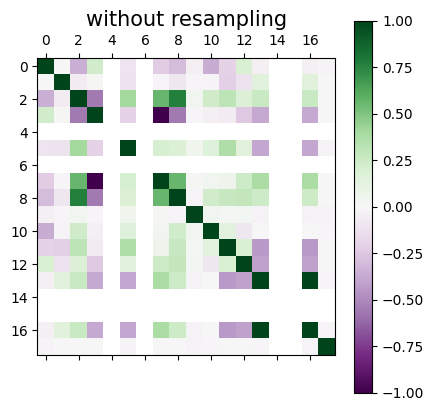

In [ ]:
plt.matshow(normalized_df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

<ipython-input-31-78b6391516ce>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(list(df_experiment1.columns)), 3, i)
<ipython-input-31-78b6391516ce>:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=feature, y='2-DO_Dev1', palette='Blues', data=df_experiment1)
<ipython-input-31-78b6391516ce>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(list(df_experiment1.columns)), 3, i)
<ipython-input-31-78b6391516ce>:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=feature, y='2-DO_Dev1', palette='Blues', data=df_experiment1)
<ipython-input-31-78b6391516ce>:7: UserWarning: Ignoring `palette` because no `hue` vari

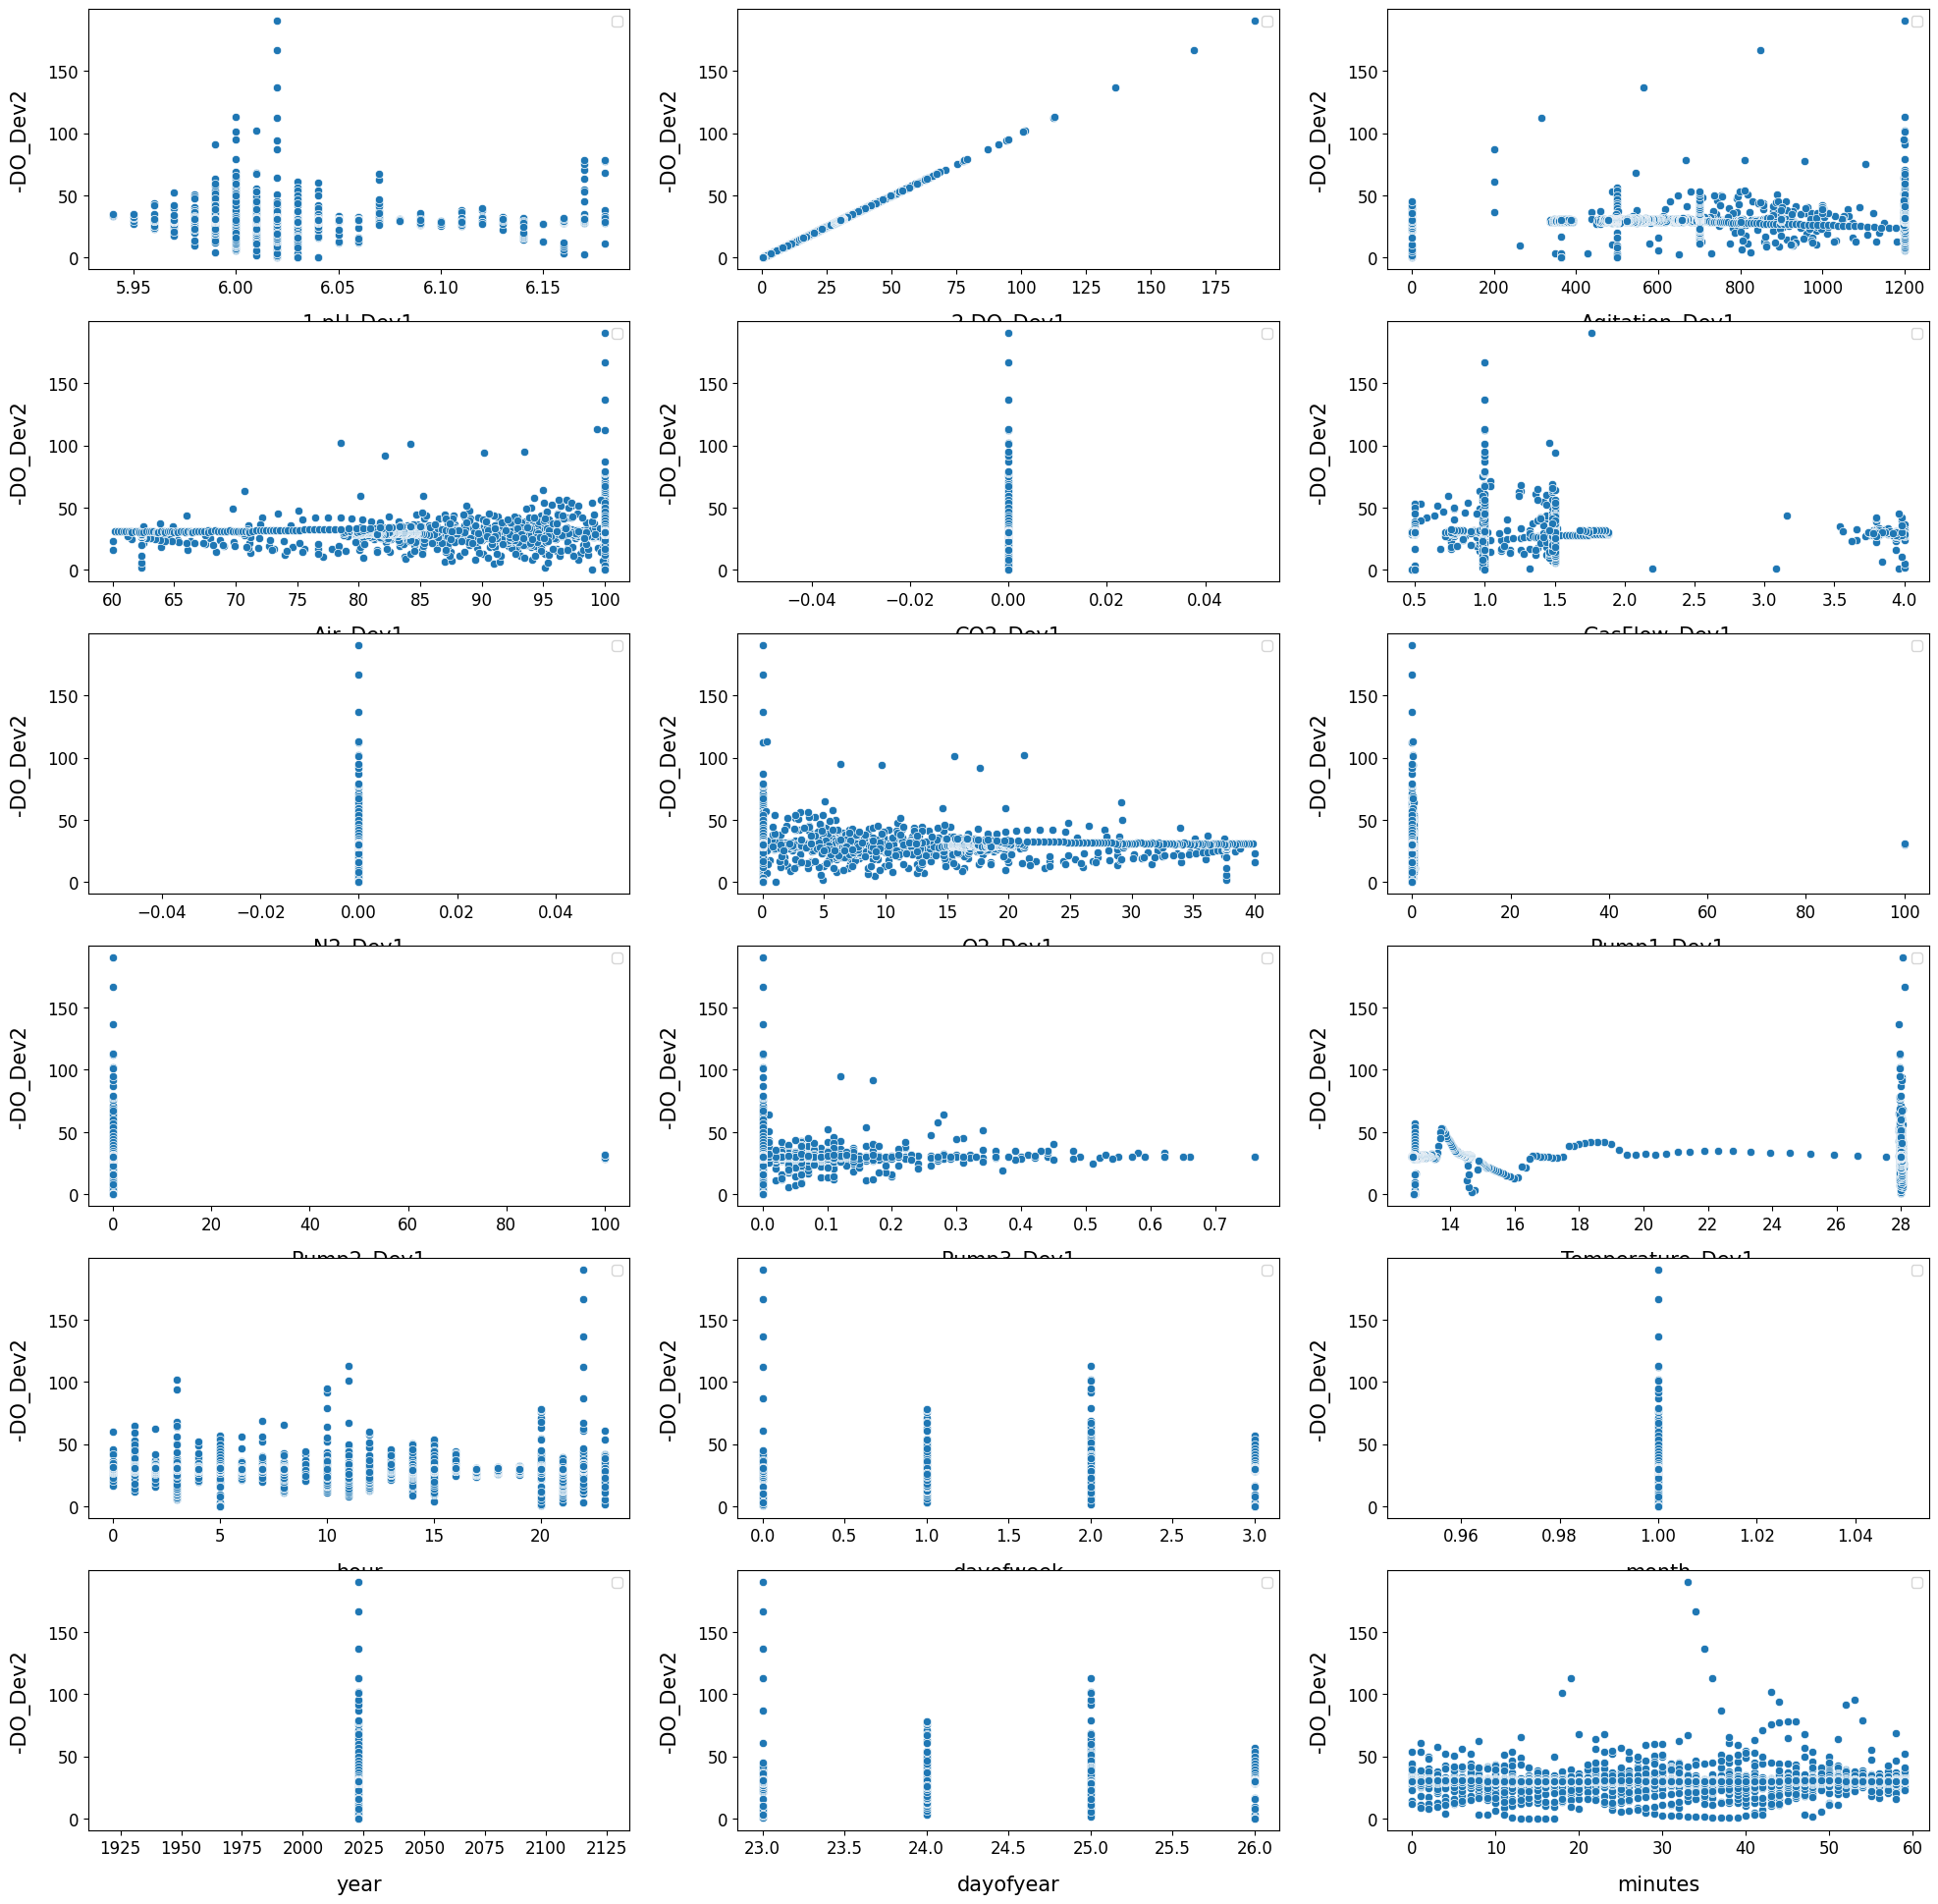

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 30))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(df_experiment1.columns),1):
    plt.subplot(len(list(df_experiment1.columns)), 3, i)
    sns.scatterplot(x=feature, y='2-DO_Dev1', palette='Blues', data=df_experiment1)

    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('-DO_Dev2', size=15, labelpad=12.5)

    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)

    plt.legend(loc='best', prop={'size': 10})

plt.show()


**from the above we can see a lot of variables that are not correlated , so we will drop them**

In [ ]:
df_experiment1=df_experiment1.drop('year', axis = 1)
df_experiment1=df_experiment1.drop('dayofyear', axis = 1)
df_experiment1=df_experiment1.drop('minutes', axis = 1)
df_experiment1=df_experiment1.drop('hour', axis = 1)
df_experiment1=df_experiment1.drop('dayofweek', axis = 1)
df_experiment1=df_experiment1.drop('month', axis = 1)
df_experiment1=df_experiment1.drop('Pump1_Dev1', axis = 1)
df_experiment1=df_experiment1.drop('Pump2_Dev1', axis = 1)
df_experiment1

,1-pH_Dev1,2-DO_Dev1,Agitation_Dev1,Air_Dev1,CO2_Dev1,GasFlow_Dev1,N2_Dev1,O2_Dev1,Pump3_Dev1,Temperature_Dev1
Time Stamp,,,,,,,,,,
2023-01-23 18:54:00,6.03,28.87,336.0,100.0,0,1.00,0,0.0,0.0,28.00
2023-01-23 18:55:00,6.03,29.09,338.0,100.0,0,1.00,0,0.0,0.0,28.00
2023-01-23 18:56:00,6.03,29.33,339.0,100.0,0,1.00,0,0.0,0.0,28.00
2023-01-23 18:57:00,6.03,29.55,342.0,100.0,0,1.00,0,0.0,0.0,28.00
2023-01-23 18:58:00,6.02,29.76,342.0,100.0,0,0.98,0,0.0,0.0,28.00
...,...,...,...,...,...,...,...,...,...,...
2023-01-26 08:33:00,6.06,29.83,477.0,100.0,0,0.50,0,0.0,0.0,12.83
2023-01-26 08:34:00,6.05,29.90,477.0,100.0,0,0.50,0,0.0,0.0,12.84
2023-01-26 08:35:00,6.06,30.01,477.0,100.0,0,0.50,0,0.0,0.0,12.84


**train/test split**

In [ ]:
train = df_experiment1.loc[df_TIME < '2023-01-25 19:30:00']
test = df_experiment1.loc[df_TIME >= '2023-01-25 19:30:00']
train_target=train['2-DO_Dev1']
test_target=test['2-DO_Dev1']
train=train.drop('2-DO_Dev1', axis = 1)
test=test.drop('2-DO_Dev1', axis = 1)


In [ ]:
model = SARIMAX(train_target, order=(2,1,2), seasonal_order=((1, 1, 1, 12)))
model_fit = model.fit()
yhat=model_fit.predict(start=test.index[0], end=test.index[-1], exog=test[['1-pH_Dev1', 'Agitation_Dev1',"Air_Dev1","O2_Dev1","GasFlow_Dev1","Temperature_Dev1"]])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


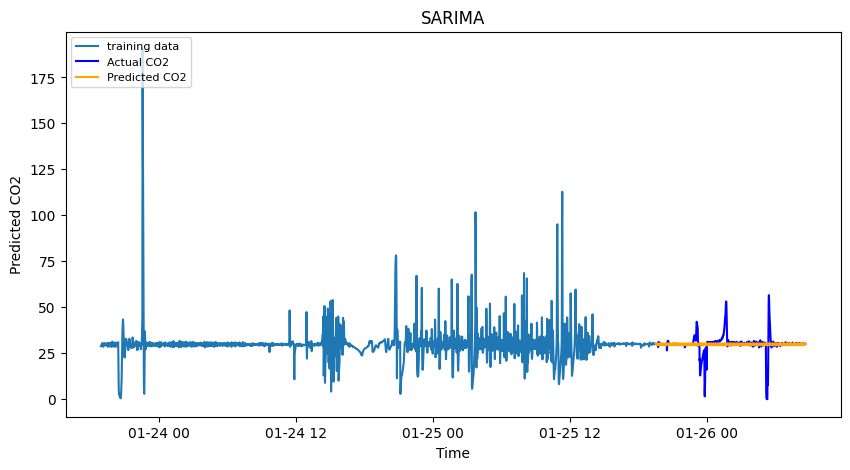

In [ ]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_target, label='training data')
plt.plot(test_target, color = 'blue', label='Actual CO2')
plt.plot(yhat, color = 'orange',label='Predicted CO2')

plt.title('SARIMA')
plt.xlabel('Time')
plt.ylabel('Predicted CO2')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**Test Stationary**

In [ ]:
from statsmodels.tsa.stattools import coint, adfuller


In [ ]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    plt.figure(figsize=(15,5), dpi=100)
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)

    plt.xlabel('Time in Years', fontsize = 25)
    plt.ylabel('Total Emissions', fontsize = 25)
    plt.legend(loc='best', fontsize = 25)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 25)
    plt.show(block= True)

In [ ]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)

    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

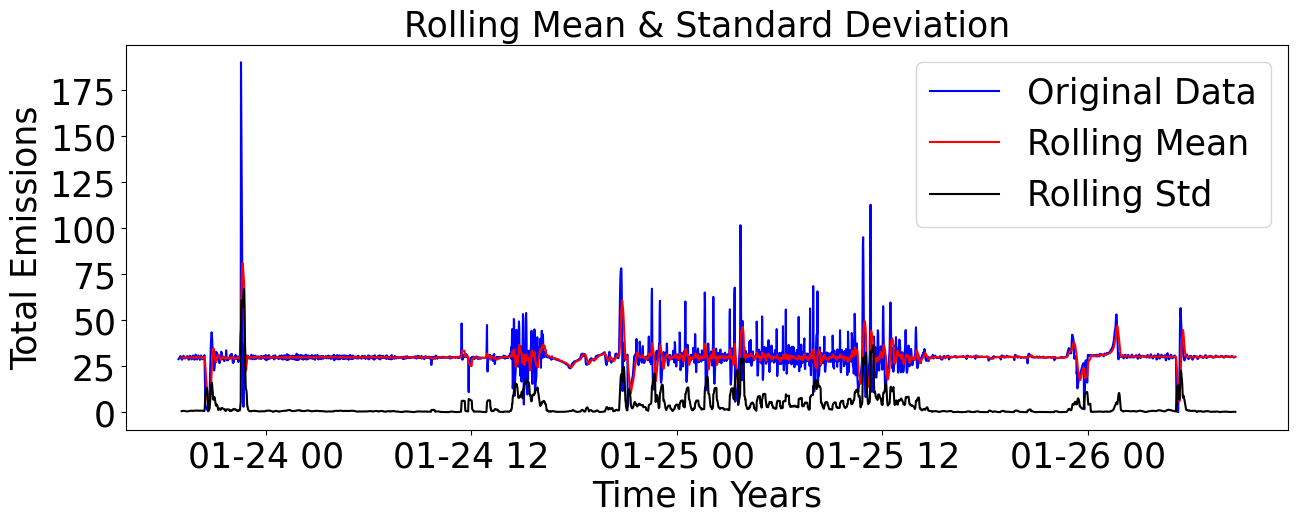

In [ ]:
TestStationaryPlot(df_experiment1['2-DO_Dev1'])

# ARIMA ON TREND

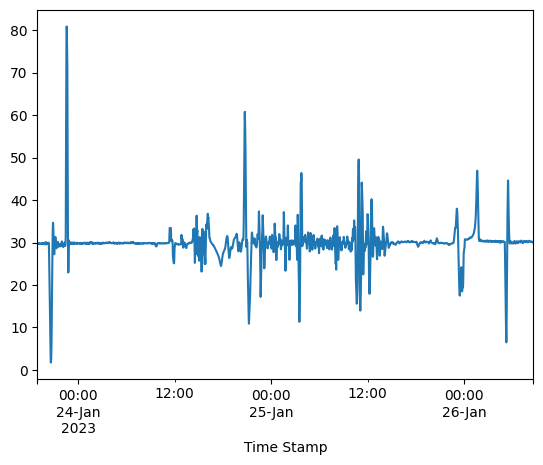

In [ ]:
trend = decomposition.trend
trend.plot()
plt.show()

In [ ]:
model_trend = SARIMAX(
trend, order= (1, 1, 1), seasonal_order=(1, 1, 1, 12))

result_trend = model_trend.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [ ]:
trend=pd.DataFrame(trend)

In [ ]:
trend

,trend
Time Stamp,
2023-01-23 18:54:00,NaN
2023-01-23 18:55:00,NaN
2023-01-23 18:56:00,NaN
2023-01-23 18:57:00,NaN
2023-01-23 18:58:00,NaN
...,...
2023-01-26 08:33:00,NaN
2023-01-26 08:34:00,NaN
2023-01-26 08:35:00,NaN


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:

trend_train = trend['trend'].loc[df_TIME < '2023-01-25 19:30:00']
trend_test = trend['trend'].loc[df_TIME >= '2023-01-25 19:30:00']

In [ ]:
forecast = result.get_forecast(steps=len(trend_test))
trend_pred = forecast.predicted_mean

In [ ]:
trend_pred=pd.DataFrame(trend_pred)

In [ ]:
trend_test=trend_test.to_frame()

In [ ]:
trend_pred = trend_pred.fillna(trend_pred["predicted_mean"].mean())
trend_test = trend_test.fillna(trend_test["trend"].mean())

In [ ]:
mse = mean_squared_error(trend_pred["predicted_mean"], trend_test["trend"][:len(trend_pred)])
rmse = np.sqrt(mse)

print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

Mean Squared Error:  16.578925601247143
Root Mean Squared Error:  4.071722682262036


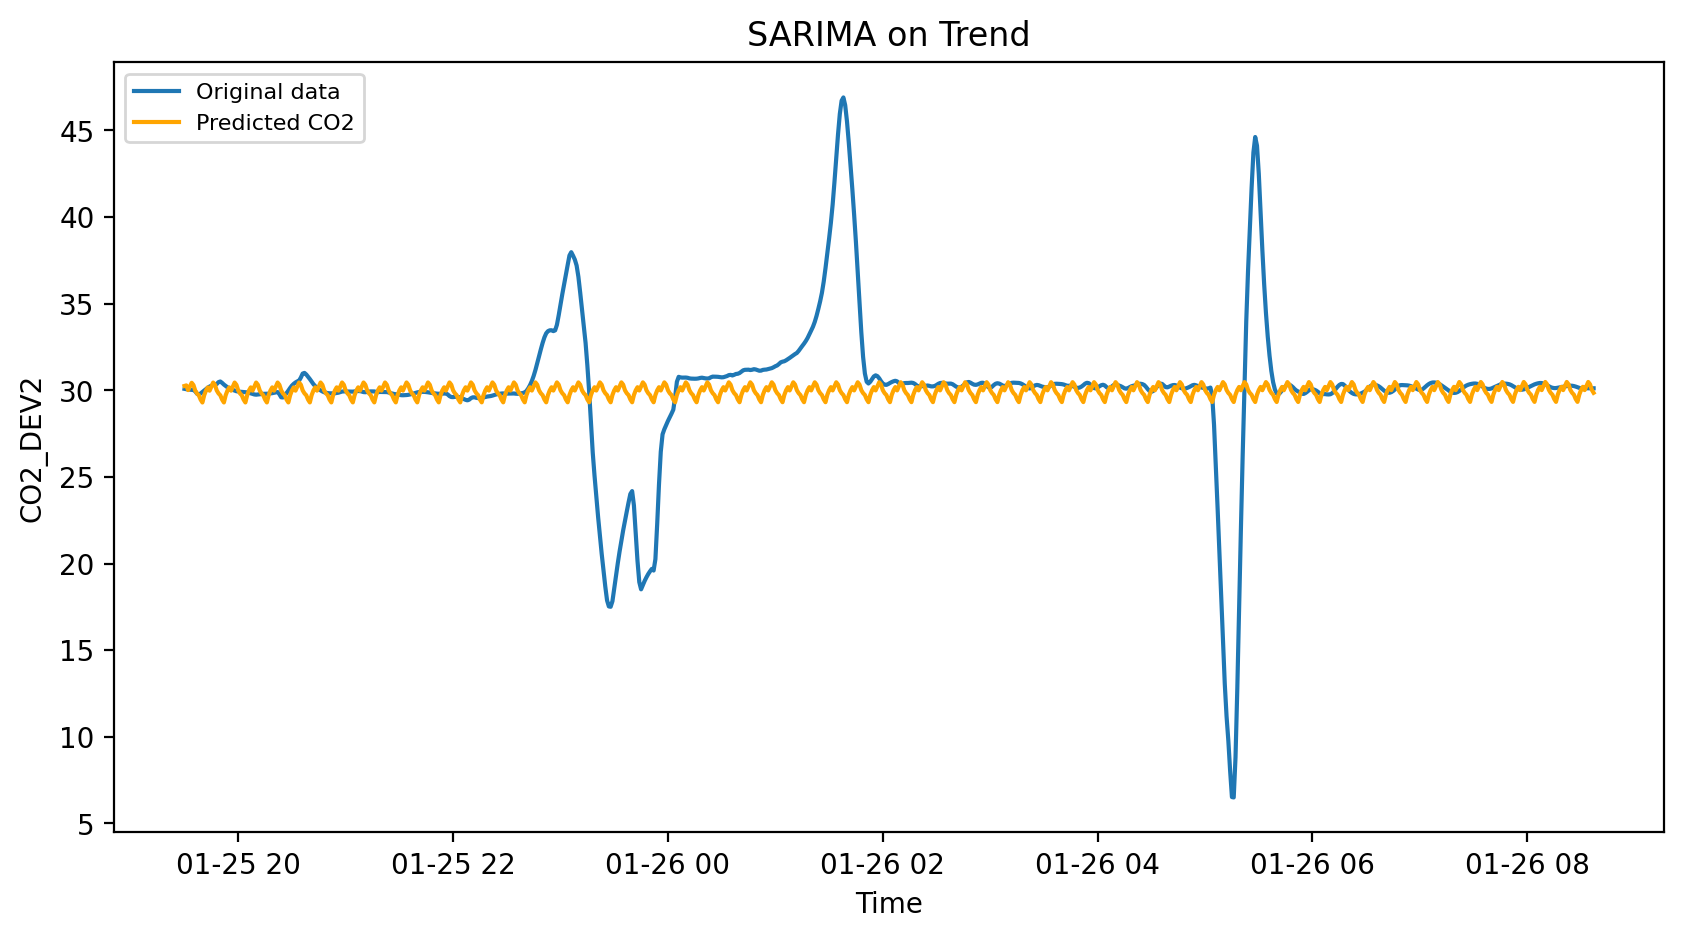

In [ ]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(trend_test["trend"], label='Original data')
plt.plot(trend_pred, color = 'orange', label='Predicted CO2')
plt.title('SARIMA on Trend')
plt.xlabel('Time')
plt.ylabel('CO2_DEV2')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# **CNN**

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM

In [ ]:
n_samples = 1000
n_timesteps = 2964
n_features = 6

In [ ]:
df_cnn=df_experiment1.copy()
target=df_cnn["2-DO_Dev1"]
df_cnn=df_cnn.drop('2-DO_Dev1', axis = 1)

In [ ]:
df_cnn

,1-pH_Dev1,Agitation_Dev1,Air_Dev1,CO2_Dev1,GasFlow_Dev1,N2_Dev1,O2_Dev1,Pump3_Dev1,Temperature_Dev1
Time Stamp,,,,,,,,,
2023-01-23 18:54:00,6.03,336.0,100.0,0,1.00,0,0.0,0.0,28.00
2023-01-23 18:55:00,6.03,338.0,100.0,0,1.00,0,0.0,0.0,28.00
2023-01-23 18:56:00,6.03,339.0,100.0,0,1.00,0,0.0,0.0,28.00
2023-01-23 18:57:00,6.03,342.0,100.0,0,1.00,0,0.0,0.0,28.00
2023-01-23 18:58:00,6.02,342.0,100.0,0,0.98,0,0.0,0.0,28.00
...,...,...,...,...,...,...,...,...,...
2023-01-26 08:33:00,6.06,477.0,100.0,0,0.50,0,0.0,0.0,12.83
2023-01-26 08:34:00,6.05,477.0,100.0,0,0.50,0,0.0,0.0,12.84
2023-01-26 08:35:00,6.06,477.0,100.0,0,0.50,0,0.0,0.0,12.84


In [ ]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_cnn, target, test_size=0.2, random_state=42)

In [ ]:

# Model using CNN
cnn_model = Sequential([
    Conv1D(filters=16, kernel_size=3, activation='relu',  input_shape=(9, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])

In [ ]:
cnn_model.compile(optimizer='adam', loss='mse')
history=cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Evaluate the models
cnn_predictions = cnn_model.predict(X_test)
cnn_mse = mean_squared_error(y_test, cnn_predictions)
print("MSE (CNN):", cnn_mse)

24/24 [==============================] - 0s 1ms/step
MSE (CNN): 62.84736919533092


In [ ]:
print(len(cnn_predictions))

741


In [ ]:
df_cnn1=pd.DataFrame(cnn_predictions)

In [ ]:
df_cnn1

,0
0,31.006432
1,30.958420
2,30.599218
3,31.133419
4,31.138809
...,...
736,30.091614
737,30.770157
738,31.210995
739,30.732597


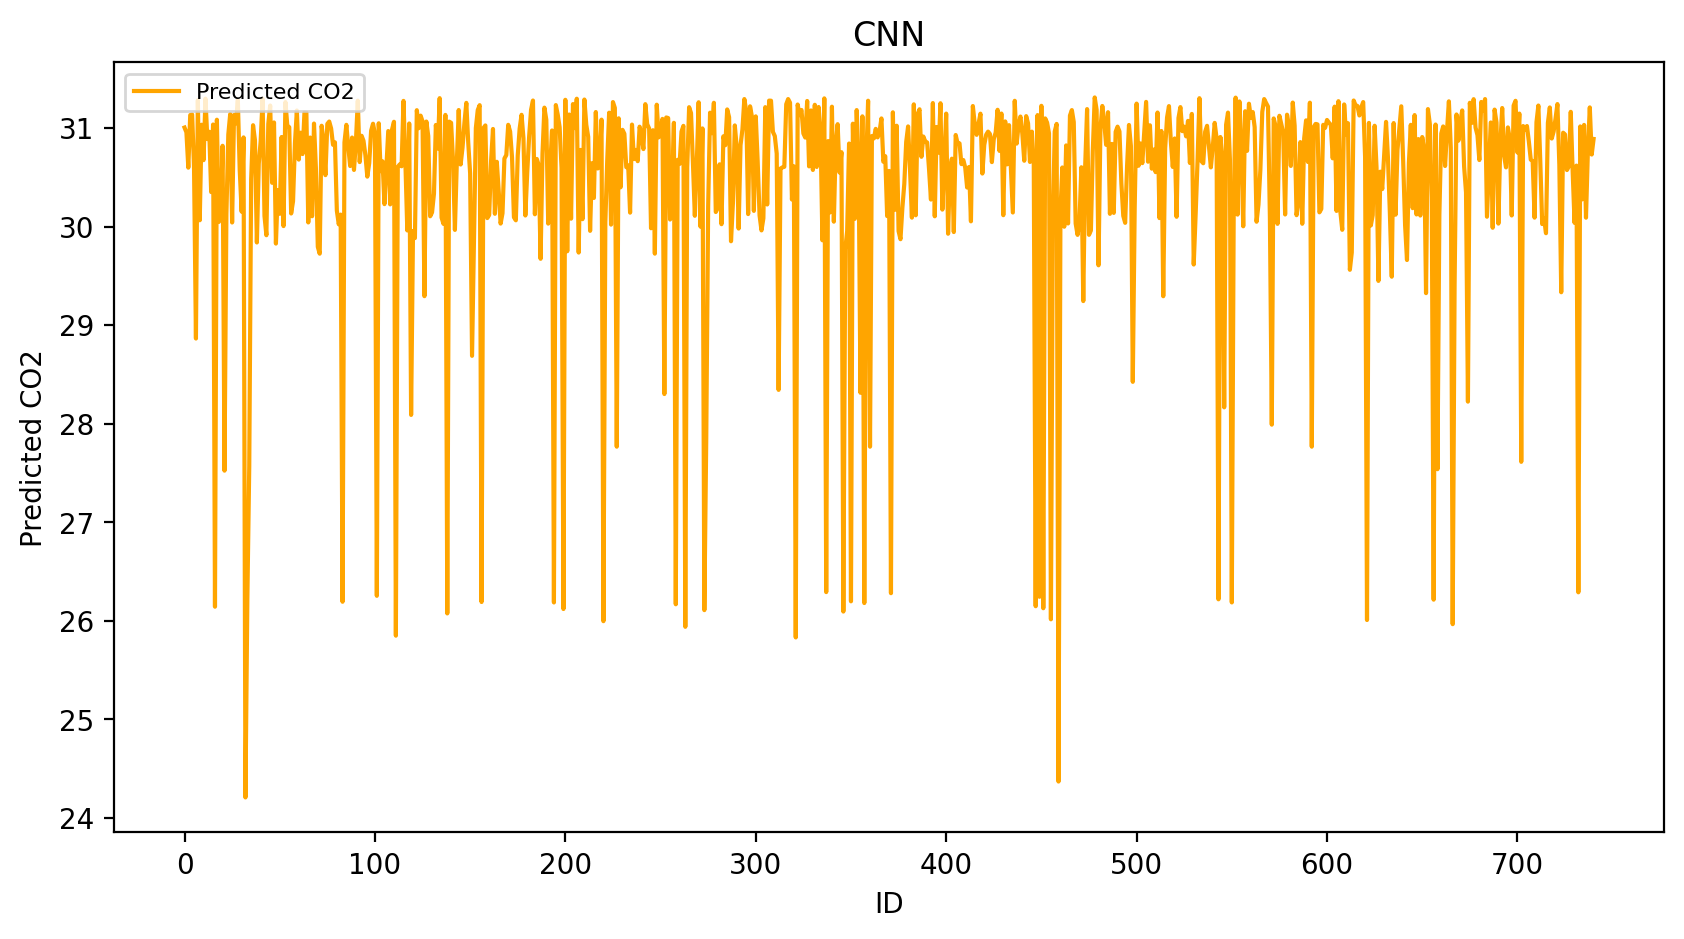

In [ ]:
plt.figure(figsize=(10,5), dpi=200)
#plt.plot(train_target, label='training data')
plt.plot(df_cnn1, color = 'orange',label='Predicted CO2')

plt.title('CNN')
plt.xlabel('ID')
plt.ylabel('Predicted CO2')
plt.legend(loc='upper left', fontsize=8)
plt.show()



# **LSTM**

In [ ]:
df_LSTM=df_experiment1.copy()
target_lstm=df_LSTM["2-DO_Dev1"]
df_LSTM=df_LSTM.drop('2-DO_Dev1', axis = 1)

In [ ]:
# Split the data into train and test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(df_LSTM, target_lstm, test_size=0.2, random_state=42)

In [ ]:
# Model using RNN (LSTM)
rnn_model = Sequential([
    LSTM(32, activation='relu', input_shape=(9,1)),
    Dense(1)
])

In [ ]:

rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=0)

# Evaluate the models
rnn_predictions = rnn_model.predict(X_test)

rnn_mse = mean_squared_error(y_test, rnn_predictions)

print("MSE (RNN):", rnn_mse)

24/24 [==============================] - 0s 1ms/step
MSE (RNN): 61.32633883285307


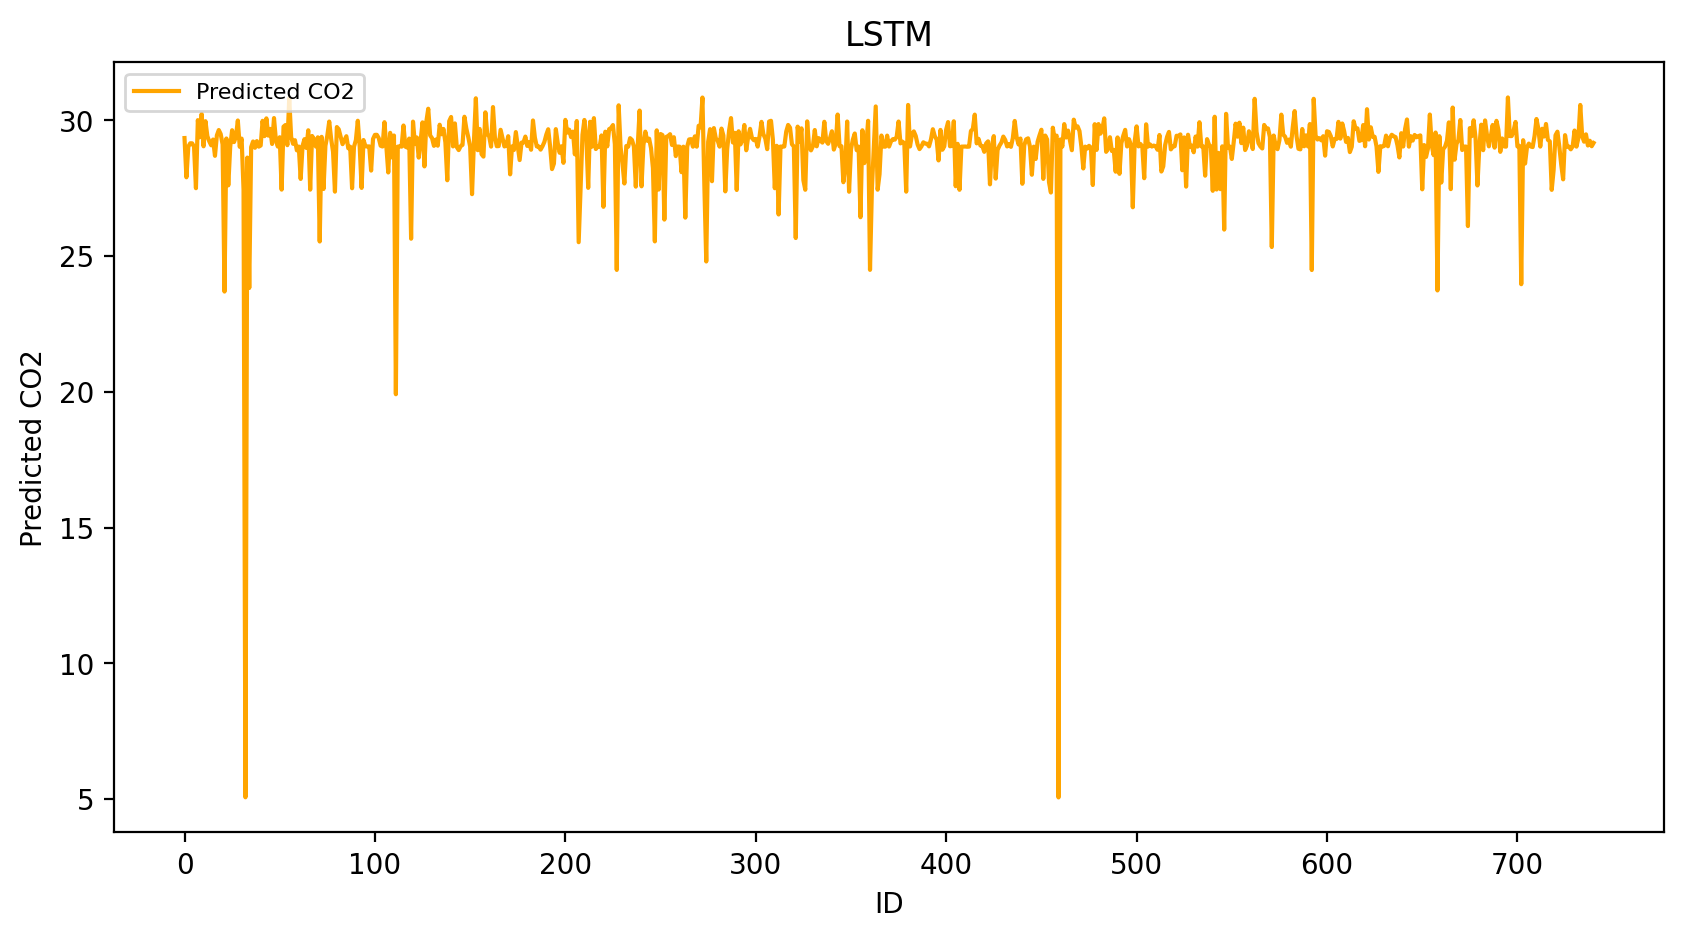

In [ ]:
plt.figure(figsize=(10,5), dpi=200)

plt.plot(rnn_predictions, color = 'orange',label='Predicted CO2')

plt.title('LSTM')
plt.xlabel('ID')
plt.ylabel('Predicted CO2')
plt.legend(loc='upper left', fontsize=8)
plt.show()


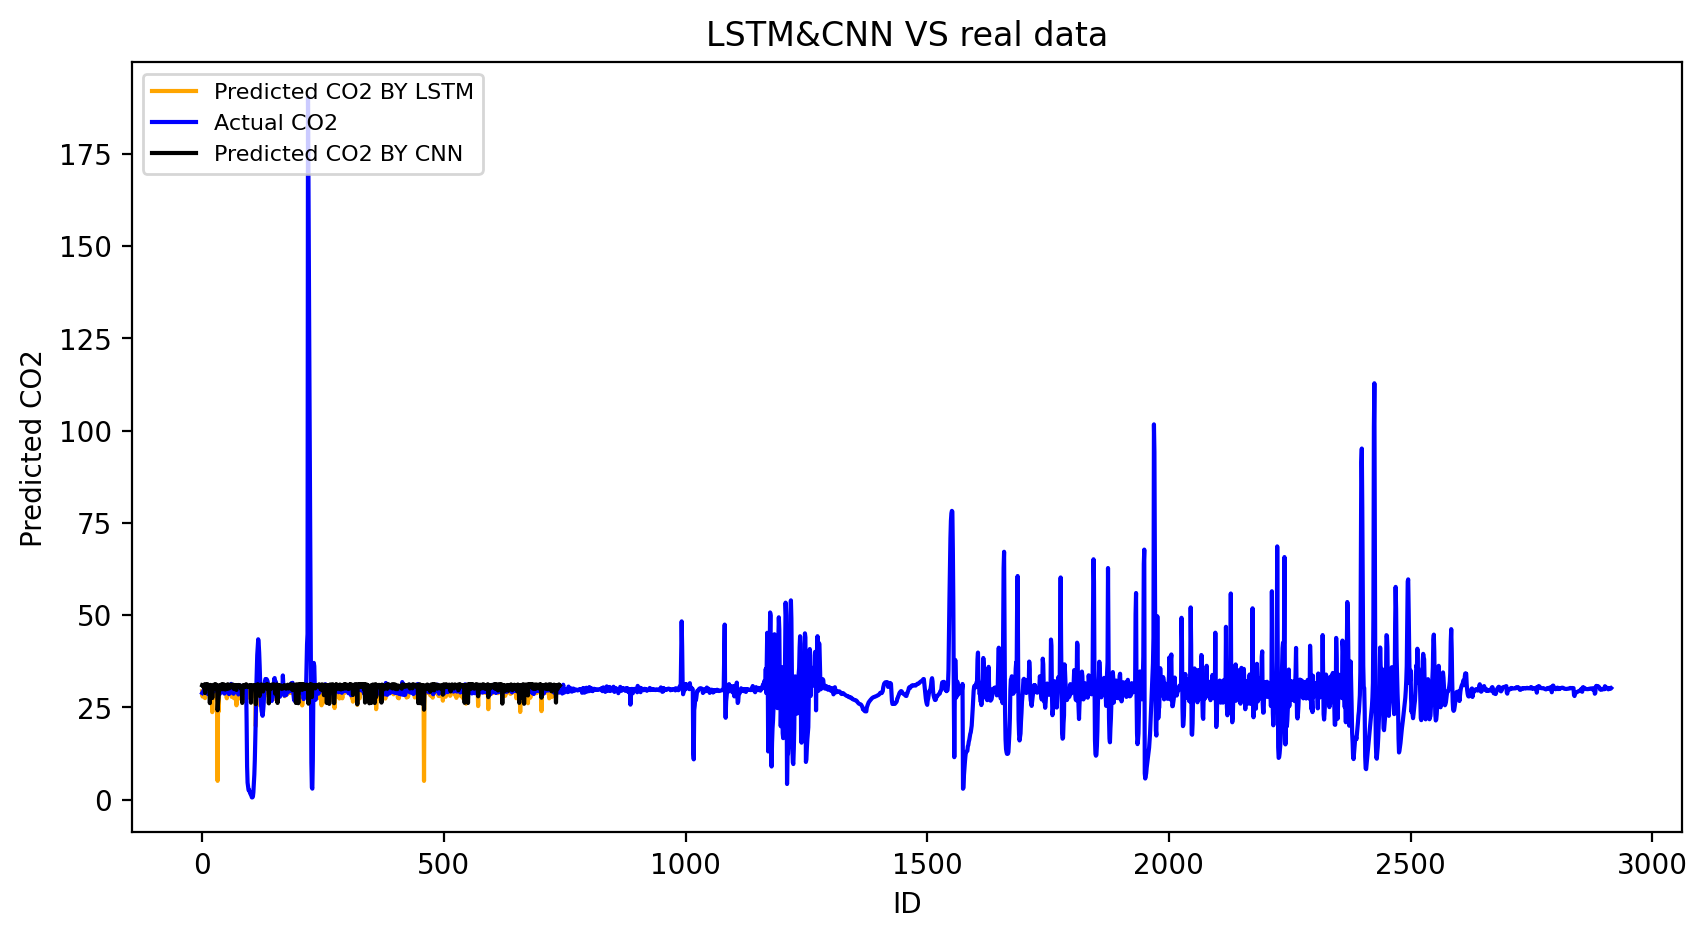

In [ ]:
plt.figure(figsize=(10,5), dpi=200)
plt.title('LSTM&CNN VS real data')
#plt.plot(train_target, label='training data')
plt.plot(rnn_predictions, color = 'orange',label='Predicted CO2 BY LSTM')
plt.plot(np.array(train_target,test_target), color = 'blue', label='Actual CO2')
plt.plot(df_cnn1, color = 'black',label='Predicted CO2 BY CNN')
plt.xlabel('ID')
plt.ylabel('Predicted CO2')
plt.legend(loc='upper left', fontsize=8)
plt.show()


#Conclusions

For conclusion, this notebook is equivalent to the 1th notebook which presents the same methodology with the same results for the run2_1 data file.